Load the dataset - 'train.csv' \
Each raw in the file contains the following values of weather value. 
- first column -> Continent
- second column -> Season
- third column -> Wind Speed
- fourth column -> Location
- fifth column -> Weather
- sixth column -> Temperature

In [64]:
import math

import random

from collections import defaultdict

import time

import matplotlib.pyplot as plt

%matplotlib inline

In [65]:
def load_data(path):
    """
    Load data from a CSV file.

    Args:
    - path (str): Path to the CSV file.

    Returns:
    - data_x (list of lists): List of feature vectors, each represented as a list of strings.
    - data_y (list): List of labels, each represented as a string.
    """
    data_x = []
    data_y = []

    with open(path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        # Strip leading/trailing whitespace and split by commas
        line_parts = list(map(str.strip, line.split(',')))

        # Extract features (first 5 elements) and label (6th element)
        features = line_parts[:5]
        label = line_parts[5]

        # Append to data lists
        data_x.append(features)
        data_y.append(label)

    return data_x, data_y


In [66]:
# Assuming load_data function is defined as discussed earlier
# Load training data
train_features, train_labels = load_data('dataset/train.csv')

# Load validation data
validate_features, validate_labels = load_data('dataset/validate.csv')

# Load test data (assuming 'dataset/test.csv' is correct for test data)
test_features, test_labels = load_data('dataset/test.csv')

# Verify lengths of train_features and train_labels
train_features_len = len(train_features)
train_labels_len = len(train_labels)

train_features_len, train_labels_len


(107, 107)

In [67]:
# Initialize dictionaries to store unique values and their encodings
unique_countries_dict = {}
unique_seasons_dict = {}
unique_windspeeds_dict = {}
unique_locations_dict = {}
unique_weathers_dict = {}
unique_temperatures_dict = {}

# Encode features in train_data
for country, season, windspeed, location, weather in train_features:
    if country not in unique_countries_dict:
        unique_countries_dict[country] = len(unique_countries_dict)
    
    if season not in unique_seasons_dict:
        unique_seasons_dict[season] = len(unique_seasons_dict)
    
    if windspeed not in unique_windspeeds_dict:
        unique_windspeeds_dict[windspeed] = len(unique_windspeeds_dict)
    
    if location not in unique_locations_dict:
        unique_locations_dict[location] = len(unique_locations_dict)
    
    if weather not in unique_weathers_dict:
        unique_weathers_dict[weather] = len(unique_weathers_dict)

# Encode temperatures in train_data
for temp in train_labels:
    if temp not in unique_temperatures_dict:
        unique_temperatures_dict[temp] = len(unique_temperatures_dict)

# Print or return the unique mappings
unique_countries_dict, unique_seasons_dict, unique_windspeeds_dict, unique_locations_dict, unique_weathers_dict, unique_temperatures_dict


({'Africa': 0, 'Australia': 1, 'North America': 2},
 {'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3},
 {'High': 0, 'Low': 1, 'Normal': 2},
 {'Coast Line': 0, 'Coastline': 1, 'Inland': 2},
 {'Rainy': 0, 'Sunny': 1, 'Cloudy': 2, 'Humid': 3},
 {'Normal': 0, 'Hot': 1, 'Cold': 2})

In [68]:
def encode_features(input_data_x, input_data_y):
    # Initialize one-hot encoding arrays for features
    encoded_country = [0] * len(unique_countries_dict)
    encoded_season = [0] * len(unique_seasons_dict)
    encoded_windspeed = [0] * len(unique_windspeeds_dict)
    encoded_location = [0] * len(unique_locations_dict)
    encoded_weather = [0] * len(unique_weathers_dict)
    
    # Retrieve indices for each feature from respective dictionaries
    country_idx = unique_countries_dict[input_data_x[0]]
    season_idx = unique_seasons_dict[input_data_x[1]]
    windspeed_idx = unique_windspeeds_dict[input_data_x[2]]
    location_idx = unique_locations_dict[input_data_x[3]]
    weather_idx = unique_weathers_dict[input_data_x[4]]
    
    # Perform one-hot encoding
    encoded_country[country_idx] = 1
    encoded_season[season_idx] = 1
    encoded_windspeed[windspeed_idx] = 1
    encoded_location[location_idx] = 1
    encoded_weather[weather_idx] = 1
    
    # Concatenate all encoded features into a single feature vector
    encoded_features_x = encoded_country + encoded_season + encoded_windspeed + encoded_location + encoded_weather
    
    # Encode label y using the unique_temperature dictionary
    encoded_label_y = unique_temperatures_dict[input_data_y]
    
    return encoded_features_x, encoded_label_y


In [69]:
def calculate_sigmoid(z):
    # Avoiding overflow and underflow issues
    if z < 0:
        sigmoid_value = math.exp(z) / (1 + math.exp(z))
    else:
        sigmoid_value = 1 / (1 + math.exp(-z))

    # Handling machine precision errors
    sigmoid_value = max(0.0001, sigmoid_value)
    sigmoid_value = min(0.9999, sigmoid_value)

    return sigmoid_value

In [70]:
def find_argmax(values):
    max_value_found = float('-inf')
    index_of_max_value = 0

    for idx, current_value in enumerate(values):
        if current_value > max_value_found:
            index_of_max_value = idx
            max_value_found = current_value

    return index_of_max_value


In [71]:
def make_prediction(input_sample, model_weights):
    # Calculate z = sum(w * x + b)
    # Here bias (b) is included in model_weights
    z = 0
    for feature_value, weight in zip(input_sample, model_weights):
        z += weight * feature_value

    # Apply sigmoid activation function to z
    return calculate_sigmoid(z)


In [72]:


def calculate_cross_entropy_loss(predicted_value, actual_value):
    y_true = actual_value
    y_pred = predicted_value

    if y_true == 1:
        return -math.log(y_pred)
    else:
        return -math.log(1 - y_pred)


In [73]:

def perform_gradient_descent(features, labels, initial_weights=None, learning_rate=0.1):
    n_features = len(features[0])

    # Initialize weights with random values (equal to the number of features in X)
    if initial_weights is None:
        initial_weights = [random.random() for _ in range(n_features)]

    total_loss = 0

    for x, y in zip(features, labels):
        y_prediction = make_prediction(x, initial_weights)
        total_loss += calculate_cross_entropy_loss(y_prediction, y)

        # Calculate gradients and update weights
        prediction_error = y_prediction - y
        for i in range(n_features):
            gradient = prediction_error * x[i]
            initial_weights[i] -= learning_rate * gradient

    # Average loss over all examples
    average_loss = total_loss / len(features)

    return initial_weights, average_loss


In [74]:
def train_binary_classifier(features_train, labels_train, learning_rate, epochs, verbose=False):
    weights = None
    training_history = []

    for epoch in range(epochs):
        weights, loss = perform_gradient_descent(features_train, labels_train, weights, learning_rate)
        training_history.append(loss)

        if verbose:
            print(f"Epoch [{epoch}]\n\t- Cross entropy loss: {loss}\n")

    return weights, training_history


In [75]:
def train_multiclass_classifier(features_train, labels_train, learning_rate, epochs, verbose=False):
    unique_classes = range(0, len(unique_temperatures_dict))  # Assuming unique_temperature contains unique class labels

    # Create binary labels for each class
    binary_labels = [[] for _ in unique_classes]

    for class_index in unique_classes:
        for label in labels_train:
            if label == class_index:
                binary_labels[class_index].append(1)
            else:
                binary_labels[class_index].append(0)

    # Train binary classifiers for each class
    classifiers = [None] * len(unique_classes)
    histories = [None] * len(unique_classes)

    for class_index, binary_label in enumerate(binary_labels):
        if verbose:
            print(f'Training for class [{class_index}]')

        weights, history = train_binary_classifier(features_train, binary_label, learning_rate, epochs, verbose=verbose)

        classifiers[class_index] = weights
        histories[class_index] = history

        if verbose:
            print('---------------------------------------------------------------------')

    return classifiers, histories


In [76]:
def predict_class(sample_features, classifiers):
    class_probabilities = []
    
    for weights in classifiers:
        class_probability = make_prediction(sample_features, weights)
        class_probabilities.append(class_probability)
    
    return find_argmax(class_probabilities)


In [77]:
def test(test_x, label, model):    
    net_accuracy = 0

    for i in range(len(test_x)):
        prediction = predict_class(test_x[i], model)        

        if prediction == label[i]:
            net_accuracy += 1              

    return net_accuracy / len(test_x)


In [78]:
x_train_set = []
y_train_set = []

for x, y in zip(train_features, train_labels):
    x, y = encode_features(x, y)
    x_train_set.append(x)
    y_train_set.append(y)


In [79]:
x_validation_set = []
y_validation_set = []

for x, y in zip(validate_features, validate_labels):
    x, y = encode_features(x, y)
    x_validation_set.append(x)
    y_validation_set.append(y)

In [80]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5]

epochs = 1000

histories = []

models = []

for eta in learning_rates:
    print(f'Learning rate: {eta}')

    start_time = time.perf_counter()

    model, history = train_multiclass_classifier(x_train_set, y_train_set, eta, epochs, verbose=True)

    time_taken = time.perf_counter() - start_time  
    
    models.append(model)
    
    histories.append(
      (   time_taken,
          histories,
          test(x_validation_set, y_validation_set, model)
      )
    )


Learning rate: 0.0001
Training for class [0]
Epoch [0]
	- Cross entropy loss: 1.528745963810205

Epoch [1]
	- Cross entropy loss: 1.5244548357569243

Epoch [2]
	- Cross entropy loss: 1.5201747371665857

Epoch [3]
	- Cross entropy loss: 1.5159057116891494

Epoch [4]
	- Cross entropy loss: 1.5116478027100095

Epoch [5]
	- Cross entropy loss: 1.5074010533442659

Epoch [6]
	- Cross entropy loss: 1.5031655064310045

Epoch [7]
	- Cross entropy loss: 1.4989412045275847

Epoch [8]
	- Cross entropy loss: 1.494728189903945

Epoch [9]
	- Cross entropy loss: 1.4905265045369192

Epoch [10]
	- Cross entropy loss: 1.4863361901045666

Epoch [11]
	- Cross entropy loss: 1.4821572879805207

Epoch [12]
	- Cross entropy loss: 1.4779898392283581

Epoch [13]
	- Cross entropy loss: 1.4738338845959804

Epoch [14]
	- Cross entropy loss: 1.4696894645100285

Epoch [15]
	- Cross entropy loss: 1.4655566190703064

Epoch [16]
	- Cross entropy loss: 1.46143538804425

Epoch [17]
	- Cross entropy loss: 1.457325810861387

In [81]:
x_test_set = []
y_test_set = []

for x, y in zip(train_features, train_labels):
    x, y = encode_features(x, y)
    x_test_set.append(x)
    y_test_set.append(y)


In [82]:
accuracy = []

for i in range(len(learning_rates)):        
    
    acc = test(x_test_set, y_test_set, models[i])
    
    accuracy.append(acc)

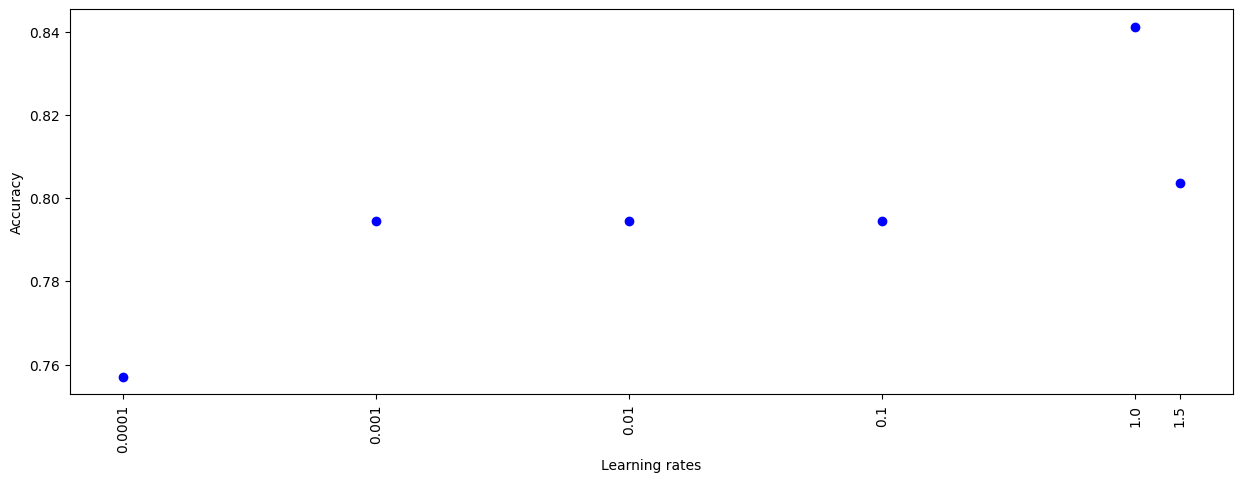

In [83]:
plt.rcParams["figure.figsize"] = (15,5)

plt.plot(list(map(math.log, learning_rates)), accuracy, 'bo')
plt.xlabel('Learning rates')
plt.ylabel('Accuracy')
plt.xticks(list(map(math.log, learning_rates)), labels=learning_rates, rotation=90)

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [84]:
accuracy

[0.7570093457943925,
 0.794392523364486,
 0.794392523364486,
 0.794392523364486,
 0.8411214953271028,
 0.8037383177570093]